Analytical approach for long-term forecasting
- the user can select the aggregation type (monthly or yearly)

In [1]:
import copy
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

## 1. Data preprocessing

- database connection
- filtering by ID
- expand_data
- aggregation -- avg?
- df[['utilization']]

In [3]:
import psycopg2

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    host="...",
    database="...",
    user="...",
    password="..."
)

# Create a cursor object to interact with the database
cursor = conn.cursor()

# Execute a SELECT query to fetch data from a table
query = "SELECT * FROM station_data_hour"
cursor.execute(query)

# Fetch all rows from the result set
rows = cursor.fetchall()

# Get the column names from the cursor description
columns = [desc[0] for desc in cursor.description]

# Create a Pandas DataFrame with the fetched data and column names
df = pd.DataFrame(rows, columns=columns)

# Close the cursor and connection
cursor.close()
conn.close()

# Print the DataFrame
print(df.head())


   location_id location_friendlyname location_friendlycode  \
0       120945      Opatija Lipovica           HRHEP-51001   
1       120945      Opatija Lipovica           HRHEP-51001   
2       120945      Opatija Lipovica           HRHEP-51001   
3       120945      Opatija Lipovica           HRHEP-51001   
4       120945      Opatija Lipovica           HRHEP-51001   

  location_address_cityname  location_address_postnumber  \
0                   Opatija                        51410   
1                   Opatija                        51410   
2                   Opatija                        51410   
3                   Opatija                        51410   
4                   Opatija                        51410   

  location_address_streetname location_address_housenumber  \
0                    Lipovica                           bb   
1                    Lipovica                           bb   
2                    Lipovica                           bb   
3                 

In [4]:
def filter_csv_by_first_column(df, value):
    '''inputs: csv_file - file with measurements (from database), value - ID'''
        
    # Filter rows based on the first column value, save the name of the station
    filtered_df = df[df.iloc[:, 0] == value]
    name = str(filtered_df.iloc[0, 1])
    print('Station: ', name)
    
    # eliminate the columns 1 to 6 that pertain to the location (address, street number etc.) 
    #filtered_df = filtered_df.iloc[:, 7:]
    
    return filtered_df, name


In [5]:
# Call the function to filter the CSV
filtered_data_zg, name2 = filter_csv_by_first_column(df, 140631)
filtered_data_zg

Station:  Zagreb Autobusni


,location_id,location_friendlyname,location_friendlycode,location_address_cityname,location_address_postnumber,location_address_streetname,location_address_housenumber,location_accesstype_title,charging_hour,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes
114294,140631,Zagreb Autobusni,HRHEP-01005,Zagreb,10000,Botićev trg,bb,Public access - Free access,2019-09-13 13:00:00+00:00,2.575758,11,0,10.991273,17
114295,140631,Zagreb Autobusni,HRHEP-01005,Zagreb,10000,Botićev trg,bb,Public access - Free access,2019-09-13 16:00:00+00:00,2.424242,11,0,7.990878,16
114296,140631,Zagreb Autobusni,HRHEP-01005,Zagreb,10000,Botićev trg,bb,Public access - Free access,2019-09-13 17:00:00+00:00,2.121212,11,0,6.992018,14
114297,140631,Zagreb Autobusni,HRHEP-01005,Zagreb,10000,Botićev trg,bb,Public access - Free access,2019-09-14 03:00:00+00:00,3.030303,11,0,13.496073,20
114298,140631,Zagreb Autobusni,HRHEP-01005,Zagreb,10000,Botićev trg,bb,Public access - Free access,2019-09-14 04:00:00+00:00,0.909091,11,0,4.048822,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125604,140631,Zagreb Autobusni,HRHEP-01005,Zagreb,10000,Botićev trg,bb,Public access - Free access,2022-10-30 21:00:00+00:00,3.181818,11,0,15.337260,21
125605,140631,Zagreb Autobusni,HRHEP-01005,Zagreb,10000,Botićev trg,bb,Public access - Free access,2022-10-31 01:00:00+00:00,17.121212,11,0,18.376942,113
125606,140631,Zagreb Autobusni,HRHEP-01005,Zagreb,10000,Botićev trg,bb,Public access - Free access,2022-10-31 02:00:00+00:00,13.333333,11,0,21.162793,88
125607,140631,Zagreb Autobusni,HRHEP-01005,Zagreb,10000,Botićev trg,bb,Public access - Free access,2022-10-31 13:00:00+00:00,5.151515,11,0,6.989488,34


In [6]:
# dropping the unnecessary columns
filtered_data_zg.drop(columns=['location_friendlycode',
                                           'location_address_cityname',
                                          'location_address_postnumber',
                                          'location_address_streetname',
                                          'location_address_housenumber'], axis=1, inplace=True)
filtered_data_zg

C:\Users\ZVNE\AppData\Local\Temp\ipykernel_8420\1731163530.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_zg.drop(columns=['location_friendlycode',


,location_id,location_friendlyname,location_accesstype_title,charging_hour,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes
114294,140631,Zagreb Autobusni,Public access - Free access,2019-09-13 13:00:00+00:00,2.575758,11,0,10.991273,17
114295,140631,Zagreb Autobusni,Public access - Free access,2019-09-13 16:00:00+00:00,2.424242,11,0,7.990878,16
114296,140631,Zagreb Autobusni,Public access - Free access,2019-09-13 17:00:00+00:00,2.121212,11,0,6.992018,14
114297,140631,Zagreb Autobusni,Public access - Free access,2019-09-14 03:00:00+00:00,3.030303,11,0,13.496073,20
114298,140631,Zagreb Autobusni,Public access - Free access,2019-09-14 04:00:00+00:00,0.909091,11,0,4.048822,6
...,...,...,...,...,...,...,...,...,...
125604,140631,Zagreb Autobusni,Public access - Free access,2022-10-30 21:00:00+00:00,3.181818,11,0,15.337260,21
125605,140631,Zagreb Autobusni,Public access - Free access,2022-10-31 01:00:00+00:00,17.121212,11,0,18.376942,113
125606,140631,Zagreb Autobusni,Public access - Free access,2022-10-31 02:00:00+00:00,13.333333,11,0,21.162793,88
125607,140631,Zagreb Autobusni,Public access - Free access,2022-10-31 13:00:00+00:00,5.151515,11,0,6.989488,34


In [7]:
def expand_data(dataframe):
    # function that expands original dataframe with all time stamps
    '''inputs: original dataframe with values for ONE station'''
    
    dataframe_copy = dataframe.copy()
    dataframe_sorted = dataframe_copy.sort_values('location_friendlyname')
    dataframe_sorted['Time'] = pd.to_datetime(dataframe_sorted['charging_hour'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize(None)
    list_names = dataframe_sorted['location_friendlyname'].unique()
    indices_all = []
    dfs = []
    
    for name in list_names:
        dataframe_slice = dataframe_sorted.loc[dataframe_copy['location_friendlyname'] == str(name)].copy().reset_index(drop=True)

        # create new dataframe with index as every hour        
        start_index = dataframe_slice['Time'].min() #starting point is the day of the first index
        end_index = dataframe_slice['Time'].max() # ending pojnt is the day of the last index
        indices = pd.date_range(start_index, end_index, freq='1H')
        indices_all.extend(indices)
        
        dataframe_slice.set_index('Time', inplace=True)
        new_dataframe = pd.DataFrame(index=indices, data=dataframe_slice)

        new_dataframe['Time'] = new_dataframe.index
        new_dataframe['location_id'] = new_dataframe['location_id'].fillna(dataframe_slice['location_id'][0])
        new_dataframe['location_friendlyname'] = new_dataframe['location_friendlyname'].fillna(dataframe_slice['location_friendlyname'][0])
        new_dataframe['location_accesstype_title'] = new_dataframe['location_accesstype_title'].fillna(dataframe_slice['location_accesstype_title'][0])
        new_dataframe['charging_hour'] = new_dataframe['charging_hour'].fillna(np.nan) 
        # charging_hour column is filled with Nan values because it will be later dropped and is not necessary
        
        new_dataframe['utilization'] = new_dataframe['utilization'].fillna(0.0)
        new_dataframe['connector_count'] = new_dataframe['connector_count'].fillna(dataframe_slice['connector_count'][0])
        new_dataframe['congested_connectors'] = new_dataframe['congested_connectors'].fillna(0.0)
        new_dataframe['energy_consumption'] = new_dataframe['energy_consumption'].fillna(0.0)
        new_dataframe['charging_minutes'] = new_dataframe['charging_minutes'].fillna(0.0)
        dfs.append(new_dataframe)
        
    dataframe_total_exp = pd.concat(dfs, ignore_index=True)
    
    return dataframe_total_exp

In [8]:
expanded_data_all = expand_data(filtered_data_zg)
expanded_data_all

,location_id,location_friendlyname,location_accesstype_title,charging_hour,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes,Time
0,140631.0,Zagreb Autobusni,Public access - Free access,2019-09-13 13:00:00+00:00,2.575758,11.0,0.0,10.991273,17.0,2019-09-13 13:00:00
1,140631.0,Zagreb Autobusni,Public access - Free access,NaT,0.000000,11.0,0.0,0.000000,0.0,2019-09-13 14:00:00
2,140631.0,Zagreb Autobusni,Public access - Free access,NaT,0.000000,11.0,0.0,0.000000,0.0,2019-09-13 15:00:00
3,140631.0,Zagreb Autobusni,Public access - Free access,2019-09-13 16:00:00+00:00,2.424242,11.0,0.0,7.990878,16.0,2019-09-13 16:00:00
4,140631.0,Zagreb Autobusni,Public access - Free access,2019-09-13 17:00:00+00:00,2.121212,11.0,0.0,6.992018,14.0,2019-09-13 17:00:00
...,...,...,...,...,...,...,...,...,...,...
27453,140631.0,Zagreb Autobusni,Public access - Free access,NaT,0.000000,11.0,0.0,0.000000,0.0,2022-10-31 10:00:00
27454,140631.0,Zagreb Autobusni,Public access - Free access,NaT,0.000000,11.0,0.0,0.000000,0.0,2022-10-31 11:00:00
27455,140631.0,Zagreb Autobusni,Public access - Free access,NaT,0.000000,11.0,0.0,0.000000,0.0,2022-10-31 12:00:00
27456,140631.0,Zagreb Autobusni,Public access - Free access,2022-10-31 13:00:00+00:00,5.151515,11.0,0.0,6.989488,34.0,2022-10-31 13:00:00


In [9]:
expanded_data_all.set_index('Time', inplace=True)
expanded_data_all

,location_id,location_friendlyname,location_accesstype_title,charging_hour,utilization,connector_count,congested_connectors,energy_consumption,charging_minutes
Time,,,,,,,,,
2019-09-13 13:00:00,140631.0,Zagreb Autobusni,Public access - Free access,2019-09-13 13:00:00+00:00,2.575758,11.0,0.0,10.991273,17.0
2019-09-13 14:00:00,140631.0,Zagreb Autobusni,Public access - Free access,NaT,0.000000,11.0,0.0,0.000000,0.0
2019-09-13 15:00:00,140631.0,Zagreb Autobusni,Public access - Free access,NaT,0.000000,11.0,0.0,0.000000,0.0
2019-09-13 16:00:00,140631.0,Zagreb Autobusni,Public access - Free access,2019-09-13 16:00:00+00:00,2.424242,11.0,0.0,7.990878,16.0
2019-09-13 17:00:00,140631.0,Zagreb Autobusni,Public access - Free access,2019-09-13 17:00:00+00:00,2.121212,11.0,0.0,6.992018,14.0
...,...,...,...,...,...,...,...,...,...
2022-10-31 10:00:00,140631.0,Zagreb Autobusni,Public access - Free access,NaT,0.000000,11.0,0.0,0.000000,0.0
2022-10-31 11:00:00,140631.0,Zagreb Autobusni,Public access - Free access,NaT,0.000000,11.0,0.0,0.000000,0.0
2022-10-31 12:00:00,140631.0,Zagreb Autobusni,Public access - Free access,NaT,0.000000,11.0,0.0,0.000000,0.0


In [10]:
expanded_data = expanded_data_all[['utilization']].copy()

### User selection

In [11]:
# the user should select several parameters:

# if the aggregation should be on on monthly or yearly basis
time_freq = 'monthly'

# type of aggregation
agg_type = 'mean'

# number of future steps
time_future = 6 # forecasting for future 6 months

# number of previous data points
time_past = 12

In [12]:
if agg_type == 'mean':
    if time_freq == 'monthly':
        df_agg = expanded_data.resample('M').mean()
    elif time_freq == 'yearly':
        df_agg = expanded_data.resample('Y').mean()
    else:
        print('Wrong value selected for time_freq.')
elif agg_type == 'sum':
    if time_freq == 'monthly':
        df_agg = expanded_data.resample('M').mean()
    elif time_freq == 'yearly':
        df_agg = expanded_data.resample('Y').mean()
    else:
        print('Wrong value selected for time_freq.')

<AxesSubplot:xlabel='Time'>

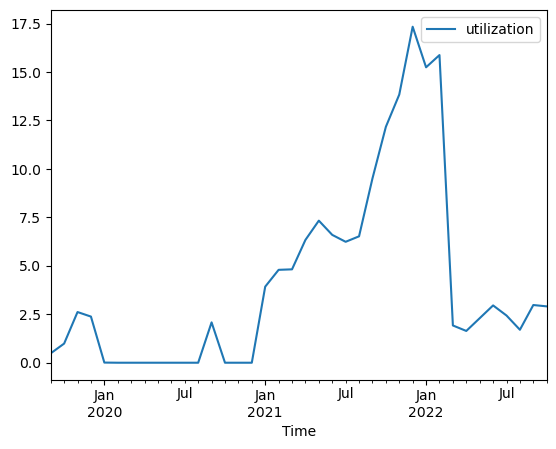

In [13]:
df_agg[['utilization']].plot()

<AxesSubplot:xlabel='Time'>

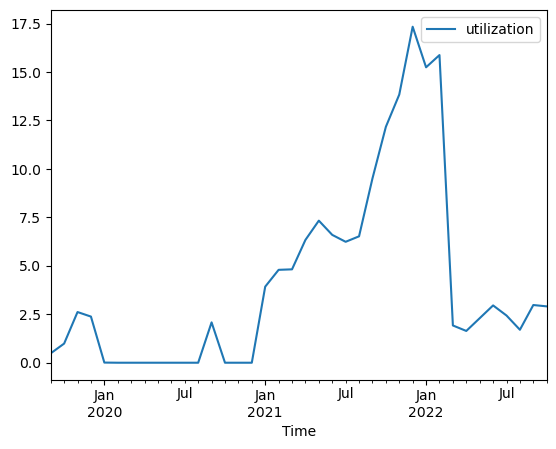

In [92]:
df_agg_utilization = df_agg[['utilization']].copy()
df_agg_utilization.plot()

### 2. Implementation of the analytical methods

4 methods are implemented, based on the R factor the best model is used for forecasting.

In [93]:
def gompertz(df, pz):
    '''input: dataframe with time stamps and utilization values, dataframe is sliced to correspond to the time_past value'''
    
    # if there are zero values for utilization, they are replaced with really small values (since it is impossible to divide by zero)
    df_copy = copy.deepcopy(df)
    
    count_zeros = df_copy.utilization[df_copy.utilization == 0].count()
    if count_zeros > 0: df_copy.replace(0, 0.000000000001, inplace=True)
        
    n_value = len(df)
    t_sum = df_copy['Time stamp'].sum()
    t_square_sum = sum([x**2 for x in df_copy['Time stamp']])
    
    logarithm = sum([np.log(np.log(pz/x)) for x in df_copy['utilization']])
    t_logarithm = sum([x*np.log(np.log(pz/y)) for x, y in zip(df_copy['Time stamp'], df_copy['utilization'])])
      
    # eq: Ax = B
    B = np.array([t_logarithm, logarithm])
    A = np.array([[t_square_sum, t_sum], [t_sum, n_value]])
    
    x = np.linalg.solve(A, B)
    
    a_par = math.exp(x[0])
    b_par = math.exp(x[1])
    
    curve_values = [a_par, b_par]
    
    '''output: list with curve parameters'''
    return curve_values

In [16]:
def exponential(df):
    '''input: dataframe with time stamps and utilization values'''
    
    # if there are zero values for utilization, they are replaced with really small values (since it is impossible to calculate ln of zero)
    df_copy = copy.deepcopy(df)
    
    count_zeros = df_copy.utilization[df_copy.utilization == 0].count()
    if count_zeros > 0: df_copy.replace(0, 0.000000000001, inplace=True)
    
    n_value = len(df_copy)
    t_sum = df_copy['Time stamp'].sum()
    t_square_sum = sum([x**2 for x in df_copy['Time stamp']])
    
    logarithm = sum([np.log(x) for x in df_copy['utilization']])
    t_logarithm = sum([x*np.log(y) for x, y in zip(df_copy['Time stamp'], df_copy['utilization'])])
    
    print(t_logarithm)
    
    # eq: Ax = B
    B = np.array([t_logarithm, logarithm])
    A = np.array([[t_square_sum, t_sum], [t_sum, n_value]])
    
    x = np.linalg.solve(A, B)
    
    a_par = x[0]
    b_par = x[1]
    
    curve_values = [a_par, b_par]
    
    '''output: list with curve parameters'''
    return curve_values

In [17]:
def polynomial(df):
    '''input: dataframe with time stamps and utilization values'''
    
    # if there are zero values for utilization, they are replaced with really small values
    df_copy = copy.deepcopy(df)
    
    n_value = len(df_copy)
    t_sum = df_copy['Time stamp'].sum()
    t_square_sum = sum([x**2 for x in df_copy['Time stamp']])
    t_cube_sum = sum([x**3 for x in df_copy['Time stamp']])
    t_fourth_sum = sum([x**4 for x in df_copy['Time stamp']])
    
    util_p = df_copy['utilization'].sum()
    t_util_p = sum([x*y for x,y in zip(df_copy['Time stamp'], df_copy['utilization'])])
    t_square_p = sum([(x**2)*y for x,y in zip(df_copy['Time stamp'], df_copy['utilization'])])
    
    # eq: Ax = B
    B = np.array([util_p, t_util_p, t_square_p])
    A = np.array([[n_value, t_sum, t_square_sum], 
                  [t_sum, t_square_sum, t_cube_sum], 
                  [t_square_sum, t_cube_sum, t_fourth_sum]])
    
    x = np.linalg.solve(A, B)
    
    a_par = x[0]
    b_par = x[1]
    c_par = x[2]
    
    curve_values = [a_par, b_par, c_par]
    
    '''output: list with curve parameters'''
    return curve_values

In [18]:
def logarithmic(df):
    '''input: dataframe with time stamps and utilization values'''
    
    # if there are zero values for utilization, they are replaced with really small values (since it is impossible to calculate ln of zero)
    df_copy = copy.deepcopy(df)
    
    count_zeros = df_copy.utilization[df_copy.utilization == 0].count()
    if count_zeros > 0: df_copy.replace(0, 0.000000000001, inplace=True)
    
    n_value = len(df_copy)
    t_sum = df_copy['Time stamp'].sum()
    t_square_sum = sum([x**2 for x in df_copy['Time stamp']])
    
    logarithm = sum([np.log10(x) for x in df_copy['utilization']])
    t_logarithm = sum([x*np.log10(y) for x, y in zip(df_copy['Time stamp'], df_copy['utilization'])])
    
    print(t_logarithm)
    
    # eq: Ax = B
    B = np.array([t_logarithm, logarithm])
    A = np.array([[t_square_sum, t_sum], [t_sum, n_value]])
    
    x = np.linalg.solve(A, B)
    
    a_par = x[0]
    b_par = x[1]
    
    curve_values = [a_par, b_par]
    
    '''output: list with curve parameters'''
    return curve_values

In [19]:
def error_function(original_df, estimated_df):
    '''inputs: original_df - aggregated values of utilization, estimated_df - values estimated using the functions'''
    
    # avg_value is average of the original_df
    avg_value =  original_df['utilization'].mean()
    
    first = sum([(x-y)**2 for x,y in zip(original_df['utilization'], estimated_df['utilization'])])
    second = sum([(x - avg_value)**2 for x in original_df['utilization']])
    
    print(avg_value)
    print(first)
    print(second)
    
    r_factor = np.sqrt(1 - first/second)
    
    '''output: error factor'''
    return r_factor   

In [95]:
df_sliced = df_agg_utilization.iloc[-1*time_past:]
df_sliced

,utilization
Time,
2021-11-30,13.836490
2021-12-31,17.337895
2022-01-31,15.244379
2022-02-28,15.875271
2022-03-31,1.922654
2022-04-30,1.639520
2022-05-31,2.297165
2022-06-30,2.956860
2022-07-31,2.435850


In [96]:
df_sliced['Time stamp'] = list(range(1, len(df_sliced) + 1))
df_sliced

C:\Users\ZVNE\AppData\Local\Temp\ipykernel_8420\2721285152.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sliced['Time stamp'] = list(range(1, len(df_sliced) + 1))


,utilization,Time stamp
Time,,
2021-11-30,13.836490,1
2021-12-31,17.337895,2
2022-01-31,15.244379,3
2022-02-28,15.875271,4
2022-03-31,1.922654,5
2022-04-30,1.639520,6
2022-05-31,2.297165,7
2022-06-30,2.956860,8
2022-07-31,2.435850,9


Note: if we want to forecast utilization of say October 2023, then our t = 36

In [97]:
gompertz(df_sliced, 50)

[1.107476058457349, 1.1460783569429727]

In [98]:
exponential(df_sliced)

86.4290368420589


[-0.19619102918986742, 2.742989818147086]

In [99]:
# here we find the best possible function for predictions
parameters_gomp = gompertz(df_sliced, 150)
parameters_exp = exponential(df_sliced)
parameters_poly = polynomial(df_sliced)
parameters_log = logarithmic(df_sliced)

86.4290368420589
37.53565377671902


In [100]:
print('Original Gompertz expression: p = pz * e^[-b*(a^t)]')
print(r'Gompertz function: p = 100 * e^[-%f*%f^t]' % (parameters_gomp[1], parameters_gomp[0]))

Original Gompertz expression: p = pz * e^[-b*(a^t)]
Gompertz function: p = 100 * e^[-2.248568*1.065939^t]


In [101]:
print('Original exponential function: p = e^[a*t + b]')
print(r'Exponential function: p = e^[%f*t + %f]' % (parameters_exp[0], parameters_exp[1]))

Original exponential function: p = e^[a*t + b]
Exponential function: p = e^[-0.196191*t + 2.742990]


In [102]:
print('Original polynomial expression. p = a + b*t + c*t^2')
print(r'Polynomial function: p = %f + %f * t + %f * t^2' % (parameters_poly[0], parameters_poly[1], parameters_poly[2]))

Original polynomial expression. p = a + b*t + c*t^2
Polynomial function: p = 22.505673 + -4.202129 * t + 0.213585 * t^2


In [103]:
print('Original logarithmic function: log p = a*t + b')
print(r'Logarithmic function: log p = %f * t + %f' % (parameters_log[0], parameters_log[1]))

Original logarithmic function: log p = a*t + b
Logarithmic function: log p = -0.085205 * t + 1.191265


In [104]:
def use_gompertz(parameters, original_df):
    estimated_df = pd.DataFrame([100 * math.exp(-1 * parameters[1] * math.pow(parameters[0], x)) for x in original_df['Time stamp']], 
                              columns = ['utilization'])
    pom_df = original_df.reset_index()
    estimated_df['Time stamp'] = copy.deepcopy(pom_df['Time stamp'])
    estimated_df.set_index('Time stamp', drop=True, inplace=True)
    return estimated_df

def use_exp(parameters, original_df):
    estimated_df = pd.DataFrame([math.exp(parameters[0] * x + parameters[1]) for x in original_df['Time stamp']],
                            columns = ['utilization'])
    pom_df = original_df.reset_index()
    estimated_df['Time stamp'] = copy.deepcopy(pom_df['Time stamp'])
    estimated_df.set_index('Time stamp', drop=True, inplace=True)
    return estimated_df

def use_poly(parameters, original_df):
    estimated_df = pd.DataFrame([parameters[0] + parameters[1] * x + parameters[2] * (x**2) for x in original_df['Time stamp']],
                             columns = ['utilization'])
    pom_df = original_df.reset_index()
    estimated_df['Time stamp'] = copy.deepcopy(pom_df['Time stamp'])
    estimated_df.set_index('Time stamp', drop=True, inplace=True)
    return estimated_df

def use_log(parameters, original_df):
    estimated_df = pd.DataFrame([math.pow(10, (parameters[0] * x + parameters[1])) for x in original_df['Time stamp']],
                            columns = ['utilization'])
    pom_df = original_df.reset_index()
    estimated_df['Time stamp'] = copy.deepcopy(pom_df['Time stamp'])
    estimated_df.set_index('Time stamp', drop=True, inplace=True)
    return estimated_df
    

In [105]:
estimated_gomp = use_gompertz(parameters_gomp, df_sliced)

estimated_exp = use_exp(parameters_exp, df_sliced)

In [107]:
df_sliced

,utilization,Time stamp
Time,,
2021-11-30,13.836490,1
2021-12-31,17.337895,2
2022-01-31,15.244379,3
2022-02-28,15.875271,4
2022-03-31,1.922654,5
2022-04-30,1.639520,6
2022-05-31,2.297165,7
2022-06-30,2.956860,8
2022-07-31,2.435850,9


In [108]:
estimated_poly = use_poly(parameters_poly, df_sliced)

estimated_log = use_log(parameters_log, df_sliced)
estimated_log

,utilization
Time stamp,
1,12.766171
2,10.491944
3,8.622859
4,7.086742
5,5.824276
6,4.786712
7,3.933984
8,3.233165
9,2.657194


In [109]:
estimated_poly

,utilization
Time stamp,
1,18.517129
2,14.955755
3,11.821551
4,9.114518
5,6.834654
6,4.981961
7,3.556438
8,2.558085
9,1.986903


In [110]:
r_gomp = error_function(df_sliced, estimated_gomp)
r_exp = error_function(df_sliced, estimated_exp)
r_poly = error_function(df_sliced, estimated_poly)
r_log = error_function(df_sliced, estimated_log)

factors = {r_gomp:'Gompertz', r_exp:'Exponential', r_poly:'Polynomial', r_log:'Logarithmic'}

6.761025721519193
317.62320062013197
474.4813041485227
6.761025721519193
200.7129646358243
474.4813041485227
6.761025721519193
123.00314116852144
474.4813041485227
6.761025721519193
200.71296463582397
474.4813041485227


In [112]:
print(r_gomp, r_exp, r_poly, r_log)

0.5749683349754527 0.7595949321620369 0.8606758588345559 0.7595949321620373


In [113]:
max(factors)

0.8606758588345559

In [115]:
best_function = factors.get(max(factors))
best_function

'Polynomial'

### Predictions

In [116]:
if best_function == 'Polynomial':
    pom_df = pd.DataFrame(list(range(time_past + 1, time_past + time_future + 1)), columns = ['Time stamp'])
    forecast_df = use_poly(parameters_poly, pom_df)
elif best_function == ' Gompertz':
    pom_df = pd.DataFrame(list(range(time_past + 1, time_past + time_future + 1)), columns = ['Time stamp'])
    forecast_df = use_gompertz(parameters_gomp, pom_df)
elif best_function == 'Logarithmic':
    pom_df = pd.DataFrame(list(range(time_past + 1, time_past + time_future + 1)), columns = ['Time stamp'])
    forecast_df = use_log(parameters_log, pom_df)
elif best_function == 'Exponential':
    pom_df = pd.DataFrame(list(range(time_past + 1, time_past + time_future + 1)), columns = ['Time stamp'])
    forecast_df = use_exp(parameters_exp, pom_df) 
else: print('There is an error in the estimation of the best function.')

In [117]:
forecast_df

,utilization
Time stamp,
13,3.973874
14,5.538543
15,7.530381
16,9.949390
17,12.795569
18,16.068918


In [118]:
estimated_poly

,utilization
Time stamp,
1,18.517129
2,14.955755
3,11.821551
4,9.114518
5,6.834654
6,4.981961
7,3.556438
8,2.558085
9,1.986903


In [119]:
df_plotting = df_sliced.set_index('Time stamp', drop=True)
df_plotting

,utilization
Time stamp,
1,13.836490
2,17.337895
3,15.244379
4,15.875271
5,1.922654
6,1.639520
7,2.297165
8,2.956860
9,2.435850


In [120]:
df_sliced

,utilization,Time stamp
Time,,
2021-11-30,13.836490,1
2021-12-31,17.337895,2
2022-01-31,15.244379,3
2022-02-28,15.875271,4
2022-03-31,1.922654,5
2022-04-30,1.639520,6
2022-05-31,2.297165,7
2022-06-30,2.956860,8
2022-07-31,2.435850,9


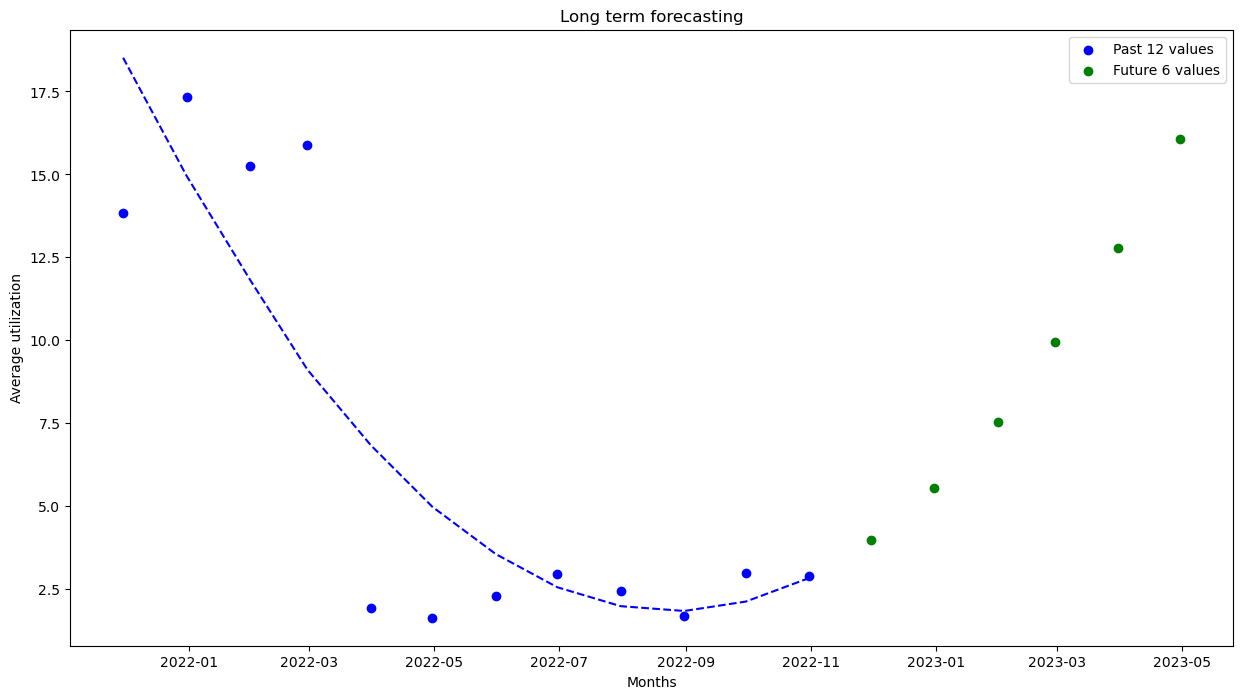

In [122]:
pom_indices = pd.date_range(start = df_sliced.index.max(), periods = 2, freq = 'M')
indices = pd.date_range(start = pom_indices.max(), periods = time_future, freq = 'M')

plt.figure(figsize=(15, 8))
plt.scatter(df_sliced.index, df_plotting['utilization'], color='b', label = 'Past 12 values')
plt.scatter(indices, forecast_df['utilization'], color='g', label = 'Future 6 values')
plt.plot(df_sliced.index, estimated_poly, color='b', linestyle='--')
plt.legend()
plt.xlabel('Months')
plt.ylabel('Average utilization')
plt.title('Long term forecasting')
plt.savefig('Long term forecasting for 6 months ahead.png')